In [1]:
#Import Dependensies
import re
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, mapper
from sqlalchemy import create_engine, desc

from sqlalchemy.ext.declarative import declarative_base # extract classes into tables
from sqlalchemy import Column, Integer, String, Float, Date, func # allow us to declare the column 

In [2]:
engine = create_engine('sqlite:///hawaii.sqlite')

In [3]:
Base = automap_base()

In [4]:
Base.prepare(engine, reflect = True)

In [5]:
Base.classes.keys()

['measurement', 'station']

In [6]:
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
#Create a Session
session = Session(engine)

### Precipitation Analysis

In [8]:
end_date =  session.query(measurement.date).order_by(measurement.date)[-1:]
start_date = end_date[0].date - datetime.timedelta(weeks=52)

In [9]:
query= session.query(measurement).order_by(measurement.date).filter(func.date(measurement.date).between(start_date,end_date[0].date))

In [10]:
def query2DictList(result):
    dictlist=[]
    keys = ['date', 'prcp']
    for row in result:
        values = [row.date, row.prcp]
        dictlist.append(dict(zip(keys, values)))
    return dictlist

In [11]:
query_df = pd.DataFrame(query2DictList(query))
query_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


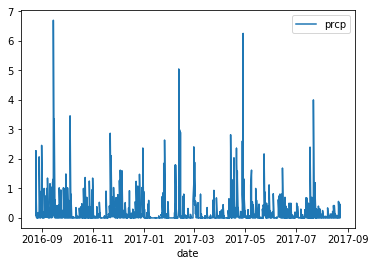

In [12]:
query_df.set_index('date', inplace=True)
plt.figure()
query_df.plot()
plt.show()

In [13]:
query_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
num_stations = session.query(measurement).group_by(measurement.station_id).count()
num_stations

9

### Station Analysis

In [15]:
active_stations = session.query(measurement.station_id, func.count(measurement.tobs).label('Freq_count'))
active_stations = active_stations.outerjoin(station).group_by(measurement.station_id)

In [16]:
active_stations.order_by(desc('Freq_count')).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

#### station USC00519281 has the highest number of observation at 2772.

In [17]:
def tobsquery2DictList(result):
    dictlist=[]
    keys = ['station_id', 'tobs']
    for row in result:
        values = [row.station_id, row.tobs]
        dictlist.append(dict(zip(keys, values)))
    return dictlist

In [18]:
res = query.filter_by(station_id= 'USC00519281').all()
query_tobs_df = pd.DataFrame(tobsquery2DictList(res))
query_tobs_df.head()

,station_id,tobs
0,USC00519281,77
1,USC00519281,80
2,USC00519281,80
3,USC00519281,75
4,USC00519281,73


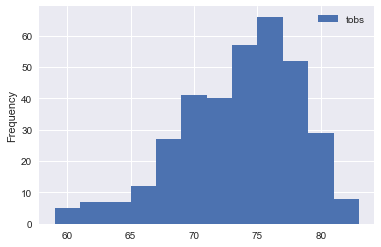

In [19]:
plt.figure()
sns.set()
query_tobs_df.plot(kind='hist', bins=12)
plt.show()

### Temperature Analysis

In [20]:
def calc_temps(start_date, end_date):
    keys = ['min_temp', 'avg_temp', 'max_temp']
    query = session.query(measurement, func.count(measurement.tobs).label('count'),
                                   func.max(measurement.tobs).label('max_temp'),
                                   func.min(measurement.tobs).label('min_temp'),
                                   func.sum(measurement.tobs).label('total_temp')
                         ).filter(func.date(measurement.date).between(start_date,end_date[0].date))
    avg_temp = query[0].total_temp / query[0].count
    values = [query[0].min_temp, avg_temp, query[0].max_temp]
    results = dict(zip(keys, values))
    return results

In [21]:
temp_info = calc_temps(start_date, end_date)
temp_info_df = pd.DataFrame(temp_info, index= [0])
error = [temp_info_df.max_temp - temp_info_df.min_temp]

<Container object of 1 artists>

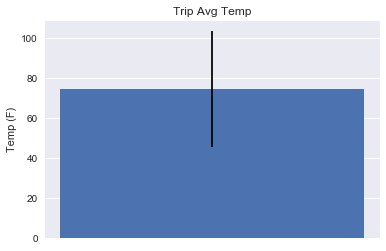

In [22]:
fig, ax = plt.subplots()
ax.set_ylabel('Temp (F)')
ax.set_xticklabels([])
ax.set_title('Trip Avg Temp')
ax.grid(b= 'off', axis= 'x')
ax.bar(0, temp_info_df.avg_temp, width= 0.05, yerr= error)